  ### **Final Project**: Baseball Optics Analysis - Exploratory Data Analysis
   - Name: Andrew Lang, Joseph Oladeji, Richard Prange
   - Class Name: MATH475 - Statistical Machine Learning

The **Track_Combo.csv** dataset contains **3,344** observations with **141 columns** from 21 different scrimmages. It includes detailed pitch-level data from college baseball scrimmages, recorded by TrackMan V3. The dataset also captures various pitch characteristics, such as the pitcher's and batter's information, pitch speed, trajectory, and confidence metrics as well as both numerical and categorical fields, and includes confidence ratings on certain metrics.

We are interested in called balls and strikes. Thus to do this we will go through a proces of eliminating pictches and columns not needed for our classification needs.

Reference:

Pifer, N. D. P. (2024, September 16). Optical tracking data from college baseball scrimmages. Mendeley Data. https://data.mendeley.com/datasets/xfnz6mkdzm/3

In [1]:
# Remove unessicary columns before eda

import pandas as pd

# Read the data
baseball_data = pd.read_csv("Track_Combo.csv")
cols_to_not_drop = ["PitchCall", "PlateLocHeight", "PlateLocSide"]

# Check for missing values in the dataset
missing_values = baseball_data.isnull().sum()
print("Missing values before filtering:")
print(missing_values)

# remove all of the colums that dont pertain to the outcome of the pitch and its location
classification_needs = baseball_data[cols_to_not_drop]
#print(classification_needs)

# Dropping rows with missing values
df_no_null = classification_needs.dropna()
print("\nDataset shape after dropping missing values:", df_no_null.shape)

# Removing the un needed pitch calls
# We dont want foul ball, strike swinging, etc as the location of those pitches may throw the model off
df_filtered = classification_needs[classification_needs["PitchCall"].isin(['StrikeCalled', 'BallCalled'])]

# remove two rows with null entries
df_filt_no_null = df_filtered.dropna()


print(df_filt_no_null.head())
print(df_filt_no_null.shape)



Missing values before filtering:
PitchNo                              0
Date                                 0
PAofInning                           0
PitchofPA                            0
PitcherId                            0
                                  ... 
HitLandingConfidence              2530
CatcherThrowCatchConfidence       3226
CatcherThrowReleaseConfidence     3226
CatcherThrowLocationConfidence    3226
System                               0
Length: 141, dtype: int64

Dataset shape after dropping missing values: (3339, 3)
       PitchCall  PlateLocHeight  PlateLocSide
2   StrikeCalled         2.30084      -0.80157
4     BallCalled         2.89414      -1.49088
10    BallCalled         1.00717      -0.16006
13    BallCalled         0.34854      -2.32798
15    BallCalled         0.70726      -2.10070
(1854, 3)


# Define the area of the strike zone and remove outliers.

In [2]:
# in this section I want to remove pitches that were above 5 ft and below 0ft in height

# Strike Zone
UPPER = 3.3773
LOWER = 1.5
SIDE = .83083

# Define the coordinates for the box (xmin, ymin, width, height)
xmin = -1 * SIDE  # value for the lower left x-coordinate of the box
ymin = LOWER  # value for the lower left y-coordinate of the box
width = 2 * SIDE # Width of the box
height = UPPER - LOWER # Height of the box


# Remove all entries in the height column greater than 5 or less than equal to 0
df_filtered = df_filt_no_null[df_filt_no_null['PlateLocHeight'] >= 0]
df_filtered = df_filtered[df_filtered['PlateLocHeight'] < 5]


print(df_filtered.shape)

(1777, 3)


We removed around 80 entries with unsatisfactory heights.



# Removing False Calls
In the following cell we will write some code to remove false balls and false strikes.

I.e if in the picture the ball is inside the strikezone but called a ball it will be removed, along with strikes called balls.

In [3]:
def remove_false_call():
    global df_filtered  # Declare df_filtered as global

    i = 0  # Initialize an index counter
    while i < len(df_filtered):
        entry = df_filtered.iloc[i]

        if entry['PitchCall'] == 'BallCalled':
            # If it's a ball but inside the strike zone, remove it
            if in_range(xmin, xmin + width, entry['PlateLocSide']) and in_range(ymin, ymin + height, entry['PlateLocHeight']):
                df_filtered = df_filtered.drop(df_filtered.index[i])
                df_filtered.reset_index(drop=True, inplace=True)  # Reset index after drop
                continue  # Skip incrementing i because the dataset has shifted
        else:
            # If it's a strike but outside the strike zone, remove it
            if not in_range(xmin, xmin + width, entry['PlateLocSide']) or not in_range(ymin, ymin + height, entry['PlateLocHeight']):
                df_filtered = df_filtered.drop(df_filtered.index[i])
                df_filtered.reset_index(drop=True, inplace=True)  # Reset index after drop
                continue  # Skip incrementing i because the dataset has shifted

        i += 1  # Increment the index only if no rows were dropped

def in_range(lower,upper,val) -> bool:
  return lower <= val <= upper

remove_false_call()


print(df_filtered.shape)


(1456, 3)


# Plotting/ Creating images for classification
Below is some code to plot some of the pitches, added a "strike-zone" in
the picture.


In [4]:
#plotting some of the entries
import matplotlib.pyplot as plt
import io
from PIL import Image

## List to store the images
image_list = []


# Get the global min and max for PlateLocSide and PlateLocHeight
x_min = df_filtered['PlateLocSide'].min() + .2
x_max = df_filtered['PlateLocSide'].max() + .2
y_min = df_filtered['PlateLocHeight'].min() + .2
y_max = df_filtered['PlateLocHeight'].max() + .2



# Create scatter plots one by one, plotting only a single entry per plot
#for i in range(len(df_filtered)):
for i in range(len(df_filtered)):
    # Get the specific entry to plot (single row)
    entry = df_filtered.iloc[i]

    # Create a new figure for each plot
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)


    # Plot just the single entry (PlateLocSide, PlateLocHeight)
    plt.scatter(entry['PlateLocSide'], entry['PlateLocHeight'], color='blue', s=100, edgecolors='k', label=f'Entry {i+1}')

    # Create the rectangle (box) and add it to plot
    box = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='orange', facecolor='none', linestyle='solid')
    plt.gca().add_patch(box)

    # Set axis limits to ensure consistent plot size
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)



    # Save the plot to a BytesIO object (in-memory image)
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, dpi=100, bbox_inches='tight', pad_inches=0.0,format='png')
    img_buffer.seek(0)

    # Open the image from the buffer and append to the list
    img = Image.open(img_buffer)
    image_list.append(img)

    # Close the plot to avoid overlapping
    plt.close()



# Classifying our images

In [5]:

import numpy as np

normalized_image_list = []

#Load an image
for i in range(len(image_list)):
    image = image_list[i]

    resized_image = image.resize((32, 32))

    # Convert the image to a numpy array
    image_array = np.array(resized_image)

    # Normalize the image to the range [0, 1]
    normalized_image = image_array.astype(np.float32) / 255.0

    # Append the processed image to the list
    normalized_image_list.append(normalized_image)






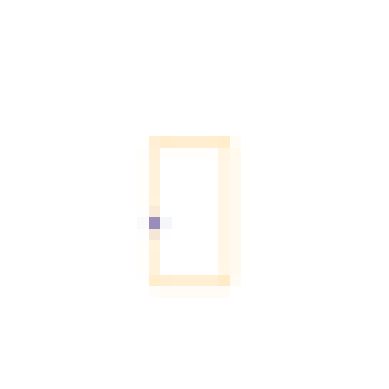

In [6]:
# Display the image using matplotlib
plt.imshow(normalized_image_list[0])
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()

In [17]:
# the variable which holds the classified images
image_classification = {"BallCalled": [], "StrikeCalled": []}
X = []
y = []

for i in range(len(df_filtered)):
    obs = df_filtered.iloc[i]
    if obs["PitchCall"] == "BallCalled":
        X.append(normalized_image_list[i])
        y.append(0)
        image_classification["BallCalled"].append(normalized_image_list[i])
    else:
        X.append(normalized_image_list[i])
        y.append(1)
        image_classification["StrikeCalled"].append(normalized_image_list[i])

print(len(X))
print(len(y))



1456
1456


From here we can see that we have classified our images into two-classes, "BallCalled" and "StrkeCalled", there are 1165 in BallCalled and 291 in StrikeCalled.

### **Quick Dataset Overview**
In this Jupyter Notebook, we loaded a dataset containing **3,341 rows** and **141 columns**. The dataset represents detailed pitch-level data from college baseball scrimmages. For our classification task, we focused on three specific columns:
- **`PitchCall`**: A categorical column with values such as `'BallCalled'`, `'StrikeCalled'`, `'StrikeSwinging'`, and `'FoulBall'`.
- **`PlateLocHeight`**: A numerical column representing the vertical position where the pitch crossed the plate.
- **`PlateLocSide`**: A numerical column representing the horizontal position where the pitch crossed the plate.

# Results:

The dataset is huge with 3341 rows and 141 columns. However we only needed 3-rows for our classification. We needed "PitchCall", "PlateLocHeight", "PlateLocSide". Pitch call was a categrocical column with values like; 'BallCalled", "StrikeCalled", StrikeSwinging", "FoulBall". However all we needed was the called pitches so we removed all the rows which contained a non-called value. Then to account for outliers, and human error when it comes to calling balls and strikes we removed all observations with pitches that had a PlateLocHeigh of greater than 5, and less than zero. As-well as removed all of the of the pitches that were misscalled. With that we took pitches that were called balls and made sure with its location was outside of our defined strike zone. We did a similar approach with called strikes were we made sure they were inside the defined strike zone.


From here we then plotted all of the pitches, we did this as there were no datasets available that contained adequate numbers, and quality of images. When plotting the images we decided to remove the borders and axis. While adding a orange rectange which is in the same locationa and size on all images. As well as a purple cirlce which represents the location the pitched crossed the plate.

After this we went through and pre-processed the images to get them ready for training. To do this we made sure all the pixels in the image were in the range [0,1] and all of the images were of equal size i.e 32x32 pixels.











# Moving into model training and predictions

In [23]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import datasets, layers, models

# images
X = np.array(X)
# labels
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the CNN model
model = models.Sequential()

# add layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output of the convolutional layers to feed into the dense layers
model.add(layers.Flatten())

# Add dense layers for classification
model.add(layers.Dense(64, activation='relu'))

# Output layer with 10 units (assuming 10 classes; adjust if necessary)
model.add(layers.Dense(10, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])






(1456, 32, 32, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Train the model
# 10 was too little bumped to 20 and accuracy shot up
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9826 - loss: 0.0390 - val_accuracy: 0.9932 - val_loss: 0.0237
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9880 - loss: 0.0316 - val_accuracy: 0.9897 - val_loss: 0.0165
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9864 - loss: 0.0385 - val_accuracy: 0.9897 - val_loss: 0.0154
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9929 - loss: 0.0247 - val_accuracy: 0.9966 - val_loss: 0.0136
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9869 - loss: 0.0314 - val_accuracy: 0.9932 - val_loss: 0.0134
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9933 - loss: 0.0235 - val_accuracy: 0.9932 - val_loss: 0.0160
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9973 - loss: 0.0183 - val_accuracy: 0.9897 - val_loss: 0.0132
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9953 - loss: 0.0166 - val_accuracy: 0.9897 - v

In [37]:
# Evaluate the model's performance on the validation set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9956 - loss: 0.0108
Test accuracy: 0.9965753555297852


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


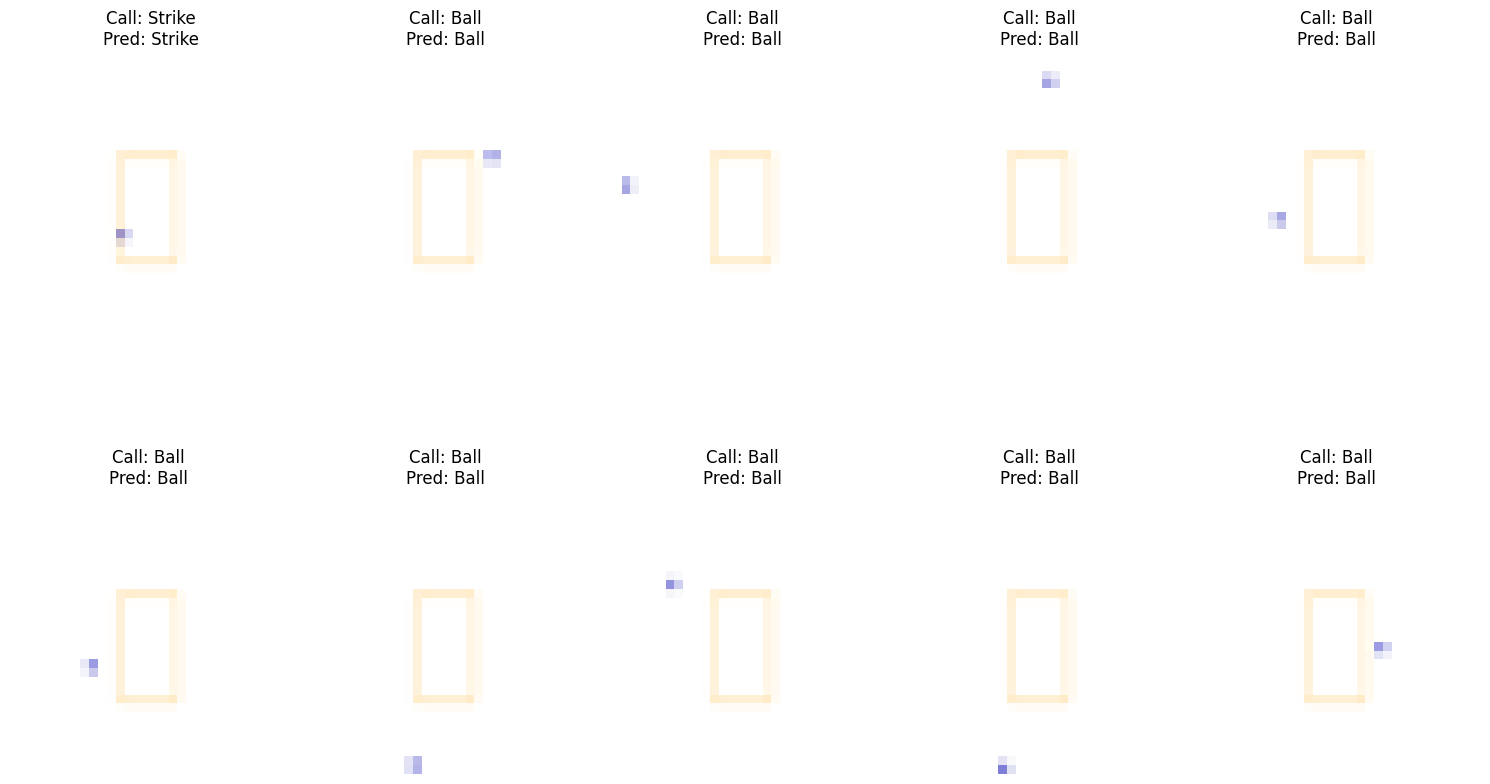

In [34]:
# Select 10 random indices from the validation set
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Create a figure to display the images
plt.figure(figsize=(15, 10))

# Loop through the 10 random images
for i, idx in enumerate(random_indices):
    # Get the image and its actual label
    image = X_test[idx]
    actual_label = y_test[idx]

    # Predict the label using the trained model
    prediction = model.predict(np.expand_dims(image, axis=0))  # Add batch dimension
    predicted_label = np.argmax(prediction)  # Get the predicted class index

    # Display the image
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(image)  # Display image
    plt.axis('off')  # Turn off axis
    plt.title(f"Call: {'Strike' if actual_label else 'Ball ' }\nPred: {'Strike' if predicted_label  else 'Ball ' }")  # Title with actual and predicted labels

# Show the plot
plt.tight_layout()
plt.show()
